In [1]:
# !pip install scikit-learn
# !pip install ipython
# !pip install line_profiler

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

import time

In [3]:
# TODO: doprecyzować typy kolumn.
# DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.

movies_df = pd.read_csv('movies_metadata.csv')

print(movies_df.columns)

unnecessary_columns = [
        'adult', 'belongs_to_collection', 'budget', 'homepage', 'id',
        'imdb_id', 'original_language', 'original_title', 'popularity',
        'poster_path', 'production_countries', 'release_date', 'revenue',
        'spoken_languages', 'status', 'tagline', 'video',
]

movies_df.drop(unnecessary_columns, axis=1, inplace=True)

print(movies_df.head())

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                                            overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  A family wedding reignites the ancient feud be...   
3  Cheated on, mistreated and steppe

C:\Users\Patryk\AppData\Local\Temp\ipykernel_20816\1662910060.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


In [4]:
# Utworzenie subsetu na podstawie pożądanych cech
movies_subset = movies_df[['title', 'overview']].copy()
print('Ilość wierszy: {}\nIlość kolumn: {}'.format(*movies_subset.shape))
print(movies_subset.head())

Ilość wierszy: 45466
Ilość kolumn: 2
                         title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  
0  Led by Woody, Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on, mistreated and stepped on, the wom...  
4  Just when George Banks has recovered from his ...  


Ilość wierszy: 44506
Ilość kolumn: 2


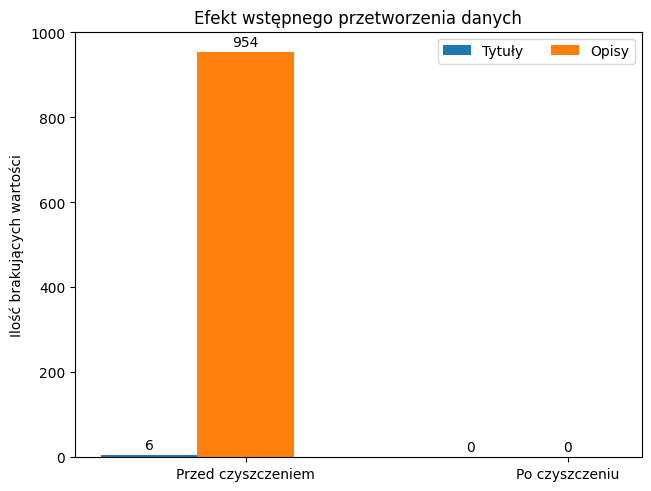

In [5]:
# numpy.array zawierający liczbę pustych wartości dla: 'title', 'overview'
missing_vals_2remove = movies_subset.isna().sum().sort_values().to_numpy()

# Nadpisujemy data frame wyrzucając przy tym puste wiersze
movies_subset.dropna(inplace=True)
print('Ilość wierszy: {}\nIlość kolumn: {}'.format(*movies_subset.shape))

missing_values = np.append(missing_vals_2remove,
                           movies_subset.isna().sum().sort_values().to_numpy())

x_labels = ['Przed czyszczeniem', 'Po czyszczeniu']
progress_dict = {
    'Tytuły': (missing_values[0], missing_values[2]),
    'Opisy': (missing_values[1], missing_values[3])
}

x = np.arange(len(x_labels))
width = 0.3
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attr, measurement in progress_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attr)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.set_ylabel('Ilość brakujących wartości')
ax.set_title('Efekt wstępnego przetworzenia danych')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper right', ncols=2)

plt.show()

In [6]:
# Wektoryzator TfIdf (Term frequency-Inverse document frequency)
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(movies_subset['overview'].values)

In [7]:
# TODO: mieerzenie czasu line_profilerem

# Macierz stworzona przy użyciu 'cosine similarity'
t1 = time.time()
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
t2 = time.time()
print('Czas: {}s'.format(round((t2-t1), 2)))
print('Ilość wierszy: {}\nIlość kolumn: {}'.format(*cosine_sim_matrix.shape))

# Macierz przedstawia kombinację podobieństwa wszystkich filmów (opisów)
print(cosine_sim_matrix[:5, :5])

Czas: 198.99643468856812
Ilość wierszy: 44506
Ilość kolumn: 44506
[[1.         0.03069614 0.01283149 0.0147528  0.03077419]
 [0.03069614 1.         0.0567421  0.03878483 0.03758384]
 [0.01283149 0.0567421  1.         0.04494666 0.05664028]
 [0.0147528  0.03878483 0.04494666 1.         0.02794615]
 [0.03077419 0.03758384 0.05664028 0.02794615 1.        ]]


In [13]:
# TODO: mieerzenie czasu line_profilerem

# Macierz stworzona przy użyciu 'linear kernel'
t1 = time.time()
linear_kernel_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)
t2 = time.time()
print('Czas: {}s'.format(round((t2-t1), 2)))
print('Ilość wierszy: {}\nIlość kolumn: {}'.format(*linear_kernel_matrix.shape))

# Ta macierz również przedstawia kombinację podobieństwa wszystkich filmów (opisów)
print(linear_kernel_matrix[:5, :5])

[[1.         0.03069614 0.01283149 0.0147528  0.03077419]
 [0.03069614 1.         0.0567421  0.03878483 0.03758384]
 [0.01283149 0.0567421  1.         0.04494666 0.05664028]
 [0.0147528  0.03878483 0.04494666 1.         0.02794615]
 [0.03077419 0.03758384 0.05664028 0.02794615 1.        ]]
